In [48]:
import pybedtools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
import bioframe
import os

Define matplotlib plotting parameters

In [3]:
matplotlib.rcParams.update({'font.size': 22})

Change Working directory to the directory where the files are

In [7]:
os.chdir("/groups/gerlich/members/MichaelMitter/PythonClub/Sequencing_data_lession_1/Data")

Look at files in directory

In [9]:
os.listdir()

['SMC3_chip_seq.bed',
 'SMC3_chip_seq.bw',
 'CTCF_chip_seq.bed',
 'XRCC4_chip-seq.bw',
 'RAD51_chip-seq.bw']

Use the pybedtools API to load in Chip-seq data for SMC3 and CTCF

In [20]:
smc3 = pybedtools.BedTool("SMC3_chip_seq.bed")
ctcf = pybedtools.BedTool("CTCF_chip_seq.bed")

This call returns a BedTool object that allows interaction with the data via various methods

In [14]:
smc3

<BedTool(SMC3_chip_seq.bed)>

In [19]:
attributes = [i for i in dir(smc3) if not "_" in i][:20]
attributes

['TEMPFILES',
 'annotate',
 'at',
 'bamtobed',
 'bamtofastq',
 'bed12tobed6',
 'bed6',
 'bedpetobam',
 'bedtobam',
 'bgzip',
 'cat',
 'closest',
 'cluster',
 'complement',
 'count',
 'coverage',
 'cut',
 'each',
 'expand',
 'features']

- dir() is a very useful function to look at attributes of an object if one does not want to consult to documention
- By excluding methods that have a "_" in it, we exclude special methods that are common to many python objects

Now we use the useful fact that pybedtool objects overload arithmetic operations to perform set operations. 
For example, the "+" operator - when both operands are BedTool objects - will perform an intersection operation.

In [21]:
smc3_ctcf_intersect = smc3 + ctcf
smc3_ctcf_intersect

<BedTool(/tmp/pybedtools.sol345rk.tmp)>

- The returned object is again a BedTool object

Now we use an API method to convert the result to a pandas dataframe. We also convert the original bedtools to be able to calculate overlap percentages.

In [22]:
smc3Frame = smc3.to_dataframe()
ctcfFrame = ctcf.to_dataframe()
smc3_ctcf_intersect_Frame = smc3_ctcf_intersect.to_dataframe()
smc3Frame

,chrom,start,end,name,score,strand
0,chr1,237576,238056,1:HeLa_SMC3_G2_2:.:237576-238056,1,.
1,chr1,804829,805584,2:HeLa_SMC3_G2_3:.:804829-805584,1,.
2,chr1,853728,856860,2:HeLa_SMC3_G2_4:.:853728-856860,1,.
3,chr1,873229,874267,1:HeLa_SMC3_G2_5:.:873232-874187|2:HeLa_SMC3_G...,2,.
4,chr1,886670,887175,1:HeLa_SMC3_G2_6:.:886670-887175,1,.
...,...,...,...,...,...,...
37119,chrX,154365622,154366423,2:HeLa_SMC3_G2_46358:.:154365622-154366423,1,.
37120,chrX,154376943,154378034,1:HeLa_SMC3_G2_49045:.:154376943-154377936|2:H...,2,.
37121,chrX,154891956,154892601,1:HeLa_SMC3_G2_49048:.:154891956-154892601,1,.
37122,chrX,155049035,155050437,1:HeLa_SMC3_G2_49049:.:155049062-155050437|2:H...,2,.


- We neatly have all the information contained in the bedfile now in a pandas dataframe
- This has the advantage of being able to use all the great methods that this class provides

Next we calculate genome-wide overlaps as percentage of SMC3 and CTCF

In [28]:
smc3Overlap = len(smc3_ctcf_intersect_Frame)/len(smc3)
ctcfOverlap = len(smc3_ctcf_intersect_Frame)/len(ctcf)
print(f"SMC3 peaks that overlap with CTCF: {np.round(smc3Overlap * 100, 2)} %")
print(f"CTCF peaks that overlap with SMC3: {np.round(ctcfOverlap * 100, 2)} %")

SMC3 peaks that overlap with CTCF: 87.84 %
CTCF peaks that overlap with SMC3: 49.71 %


Now we exploit the fact that we have everything in a pandas dataframe object to count smc3 peaks per chromosome and sort them by smc3 count

In [43]:
smc3PerChrom = smc3Frame.groupby("chrom").size().reset_index(name="counts").sort_values(by="counts", ascending=False)
smc3PerChrom

,chrom,counts
0,chr1,3672
11,chr2,2628
15,chr3,2337
17,chr5,2183
18,chr6,2104
3,chr12,2020
19,chr7,1931
2,chr11,1921
1,chr10,1859
20,chr8,1732


Now we plot this distribution

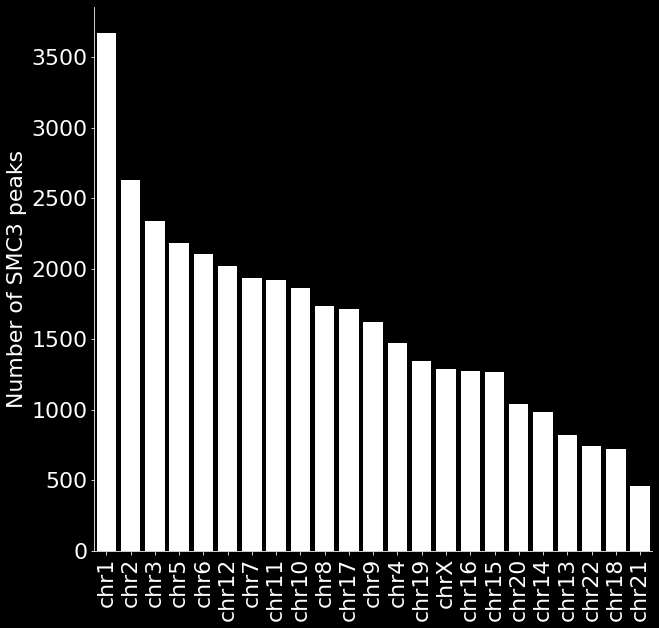

In [46]:
f, ax = plt.subplots()
sbn.barplot(x="chrom", y="counts", data=smc3PerChrom, ax=ax, color="white")
locs, labels = plt.xticks()
plt.xticks(locs, labels, rotation=90)
sbn.despine()
ax.set(xlabel="", ylabel="Number of SMC3 peaks")
f.set_size_inches(10, 10)
plt.show()

Next we get the chromosome sizes to get the density of SMC3 peaks

In [62]:
chromsizes = pd.DataFrame(bioframe.fetch_chromsizes("hg19")).reset_index()
chromsizes.columns = ["chrom", "length"]
chromsizes

,chrom,length
0,chr1,249250621
1,chr2,243199373
2,chr3,198022430
3,chr4,191154276
4,chr5,180915260
5,chr6,171115067
6,chr7,159138663
7,chr8,146364022
8,chr9,141213431
9,chr10,135534747


Now we merge them to the SMC3 count dataset

In [63]:
smc3FrameChromsizes = pd.merge(smc3PerChrom, chromsizes, on="chrom")
smc3FrameChromsizes

,chrom,counts,length
0,chr1,3672,249250621
1,chr2,2628,243199373
2,chr3,2337,198022430
3,chr5,2183,180915260
4,chr6,2104,171115067
5,chr12,2020,133851895
6,chr7,1931,159138663
7,chr11,1921,135006516
8,chr10,1859,135534747
9,chr8,1732,146364022


Calculate density of smc3

In [67]:
smc3FrameChromsizes.loc[:, "SMC3_density"] = (smc3FrameChromsizes["counts"]/smc3FrameChromsizes["length"]) * 1000000
smc3FrameChromsizes

,chrom,counts,length,SMC3_density
0,chr1,3672,249250621,14.732160
1,chr2,2628,243199373,10.805949
2,chr3,2337,198022430,11.801693
3,chr5,2183,180915260,12.066423
4,chr6,2104,171115067,12.295820
5,chr12,2020,133851895,15.091307
6,chr7,1931,159138663,12.134072
7,chr11,1921,135006516,14.228943
8,chr10,1859,135534747,13.716040
9,chr8,1732,146364022,11.833509


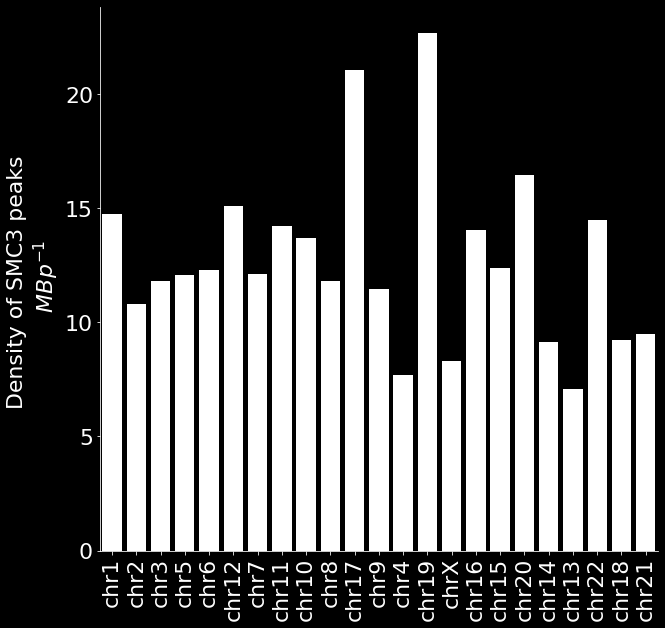

In [76]:
f, ax = plt.subplots()
sbn.barplot(x="chrom", y="SMC3_density", data=smc3FrameChromsizes, ax=ax, color="white")
locs, labels = plt.xticks()
plt.xticks(locs, labels, rotation=90)
sbn.despine()
ax.set(xlabel="", ylabel="Density of SMC3 peaks \n $MBp^{-1}$")
f.set_size_inches(10, 10)
plt.show()

- Now the distribution is much more uniform, although chromosome 17 and 19 seem to stand out

Now we count the number of CTCF peaks and look at their distribution

In [77]:
ctcfPerChrom = ctcfFrame.groupby("chrom").size().reset_index(name="counts").sort_values(by="counts", ascending=False)
ctcfPerChrom

,chrom,counts
0,chr1,6245
11,chr2,4893
15,chr3,4258
17,chr5,3872
18,chr6,3676
19,chr7,3479
2,chr11,3368
3,chr12,3284
16,chr4,3124
1,chr10,3114


In [80]:
ctcfSMC3Chromsizes = pd.merge(smc3FrameChromsizes, ctcfPerChrom, on="chrom", suffixes=("_SMC3", "_CTCF"))
ctcfSMC3Chromsizes.loc[:, "CTCF_density"] = (ctcfSMC3Chromsizes["counts_CTCF"]/ctcfSMC3Chromsizes["length"]) * 1000000
ctcfSMC3Chromsizes

,chrom,counts_SMC3,length,SMC3_density,counts_CTCF,CTCF_density
0,chr1,3672,249250621,14.732160,6245,25.055103
1,chr2,2628,243199373,10.805949,4893,20.119295
2,chr3,2337,198022430,11.801693,4258,21.502615
3,chr5,2183,180915260,12.066423,3872,21.402285
4,chr6,2104,171115067,12.295820,3676,21.482620
5,chr12,2020,133851895,15.091307,3284,24.534580
6,chr7,1931,159138663,12.134072,3479,21.861438
7,chr11,1921,135006516,14.228943,3368,24.946944
8,chr10,1859,135534747,13.716040,3114,22.975658
9,chr8,1732,146364022,11.833509,3023,20.653983


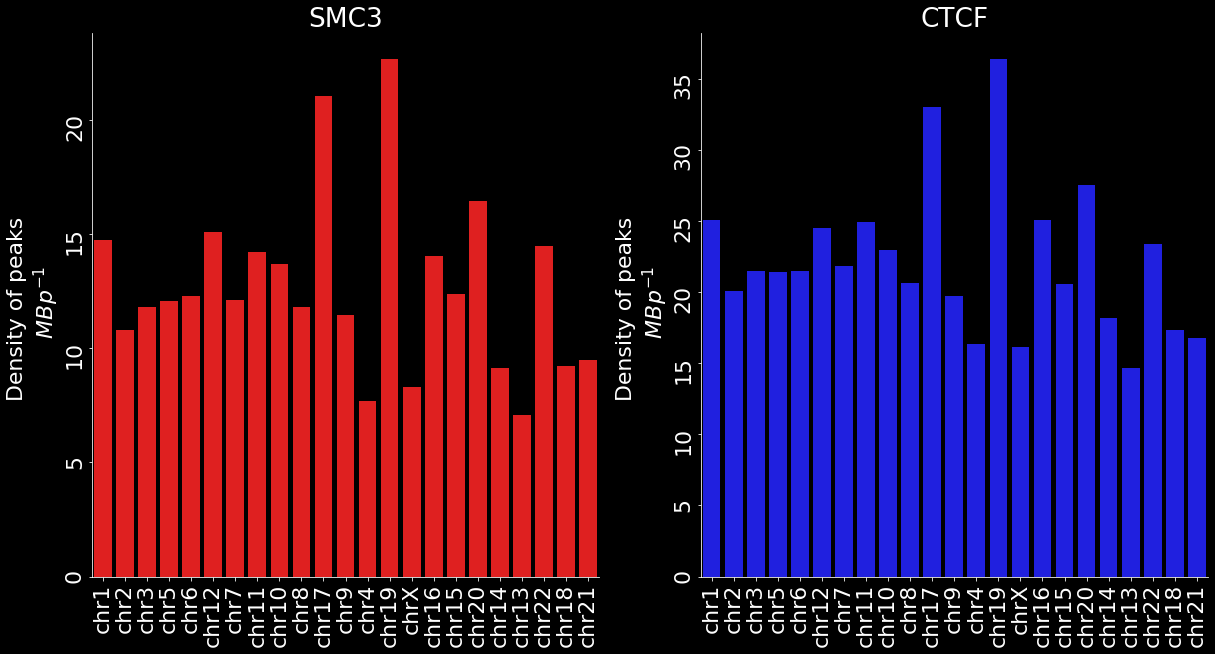

In [87]:
f, ax = plt.subplots(1, 2)
sbn.barplot(x="chrom", y="SMC3_density", data=ctcfSMC3Chromsizes, ax=ax[0], color="red")
sbn.barplot(x="chrom", y="CTCF_density", data=ctcfSMC3Chromsizes, ax=ax[1], color="blue")
ax[0].tick_params(labelrotation=90)
ax[1].tick_params(labelrotation=90)
sbn.despine()
ax[0].set(xlabel="", ylabel="Density of peaks \n $MBp^{-1}$", title="SMC3")
ax[1].set(xlabel="", ylabel="Density of peaks \n $MBp^{-1}$", title="CTCF")
f.set_size_inches(20, 10)
plt.show()

- It seems that the density of SMC3 and CTCF mirror each other quite well
- Chromosome 17 and 19 are very gene dense and since euchromatin contains smaller TADs than heterochromatin, this might explain these differences